In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [2]:

from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler
from filterflow.resampling.differentiable.biased import RegularisedTransform

from filterflow.resampling.base import NoResampling


from filterflow.state_space_model import StateSpaceModel

In [3]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.random.random(state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5

observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [4]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [5]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_observation_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [6]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T)

In [7]:
states[0]

State(particles=<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.5876165, 0.3326084]]], dtype=float32)>, log_weights=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, weights=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, log_likelihoods=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)

In [8]:
ss_model.sample_state(states[0])

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[-0.04753807, -0.05549416]]], dtype=float32)>

In [9]:
states[1]

State(particles=<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[ 0.06050362, -0.87300205]]], dtype=float32)>, log_weights=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>, weights=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, log_likelihoods=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)

In [10]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

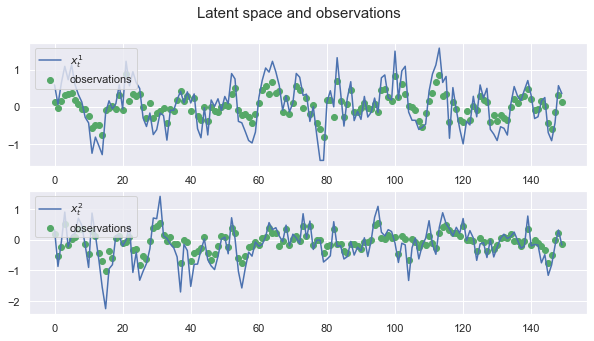

In [11]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [12]:
# store observations
batch_size = 10
n_particles = 50
dimension = 2

resampling_criterion = NeverResample()
resampling_method = NoResampling()

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)



In [13]:
observations_list = observations

In [14]:
obs_data = tf.data.Dataset.from_tensor_slices(observations_list)

In [29]:
init_g_matrix = 0.5 * np.eye(2)
init_g_cov = 0.1 * np.eye(2)

init_f_matrix = 0.5 * np.eye(2)
init_f_cov = 0.5 * np.eye(2)

g_matrix = tf.constant(init_g_matrix, dtype = tf.float32)
g_covariance = tf.constant(init_g_cov, dtype = tf.float32)


f_matrix = tf.Variable(init_f_matrix, dtype = tf.float32, trainable=True)
f_covariance =  tf.Variable(init_f_cov, dtype = tf.float32,  trainable=True)

# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)      
        

In [31]:
chol_f = tf.linalg.cholesky(f_covariance)

In [33]:
chol_f @ tf.transpose(chol_f)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.49999997, 0.        ],
       [0.        , 0.49999997]], dtype=float32)>

In [16]:
observation_series = tf.data.Dataset.from_tensor_slices(observations_list)

In [17]:
@tf.function
def loss_func():
    final_state = smc(initial_state, observation_series=observation_series, n_observations=len(observations_list), return_final = True)
    return tf.reduce_mean(-final_state.log_likelihoods / T)

In [18]:
def make_filter(f_matrix, f_covariance):
    transition_noise = tfd.MultivariateNormalTriL(loc = tf.zeros(2, dtype=tf.float32), scale_tril=f_covariance)
    transition_model = RandomWalkModel(f_matrix, transition_noise)

    observation_error = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros(2, dtype=tf.float32), tf_observation_covariance)
    observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)
    # proposal
    proposal_model = BootstrapProposalModel(transition_model)

    return SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)

In [19]:
smc = make_filter(f_matrix, f_covariance)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [20]:
@tf.function
def train_one_step(optimizer):
    var_list= [f_matrix, f_covariance]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss = loss_func()
    grads = tape.gradient(loss, var_list)
    optimizer.apply_gradients(zip(grads,var_list))
    
    return loss, grads

@tf.function
def train(optimizer, num_steps = 10):
    for step in tf.range(num_steps):
        loss, grads = train_one_step(optimizer)
        if step % (num_steps // 10) == 0:
            tf.print('Step', step, ': loss', loss)
            tf.print('grad', grads)
            tf.print('f_covariance', f_covariance @ tf.transpose(f_covariance))
            tf.print('')
    return f_matrix, f_covariance, g_matrix, g_covariance
            

In [21]:
train_one_step(optimizer)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.1035264>,
 [<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
  array([[0.2918815 , 0.00431757],
         [0.01023206, 0.33225498]], dtype=float32)>,
  <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
  array([[ 1.2073591 ,  0.        ],
         [-0.08200967,  1.2094321 ]], dtype=float32)>])

In [22]:
train(optimizer, num_steps=1000)

Step 0 : loss 0.885425746
grad [[[0.0966765434 -0.0981670767]
 [-0.0398377813 0.0999139175]], [[0.846281052 0]
 [0.226045191 0.874662936]]]
f_covariance [[0.0914546251 0.0159925651]
 [0.0159925651 0.0940571055]]

Step 100 : loss 0.585360646
grad [[[-0.00418492407 -0.00104306452]
 [-0.00756911654 -0.0021536611]], [[0.0264591947 0]
 [0.162032515 0.0602451563]]]
f_covariance [[0.0036151479 0.00277364138]
 [0.00277364138 0.00234126765]]

Step 200 : loss 0.578820407
grad [[[-0.0156283267 -0.0251885876]
 [-0.00630084239 -0.0107024442]], [[0.0627448782 0]
 [0.00151836593 0.00349897146]]]
f_covariance [[0.00761707732 0.00750073511]
 [0.00750073511 0.00742600905]]

Step 300 : loss 0.579499543
grad [[[-0.010068994 -0.0156298932]
 [-0.00656559039 -0.013333708]], [[0.0344618857 0]
 [0.0561340861 0.0432334542]]]
f_covariance [[0.0037687642 0.00363913458]
 [0.00363913458 0.00869660638]]

Step 400 : loss 0.574280918
grad [[[-0.000895873876 -0.00566065125]
 [-0.00130361342 -0.0167915486]], [[0.0294297

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.32643864, 0.49752975],
        [0.19157742, 0.466218  ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.04195254,  0.        ],
        [-0.02470391,  0.09046313]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5, 0. ],
        [0. , 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.1, 0. ],
        [0. , 0.1]], dtype=float32)>)

In [67]:
print(f_covariance @ tf.transpose(f_covariance))

tf.Tensor(
[[ 0.00345475 -0.00695822]
 [-0.00695822  0.01447789]], shape=(2, 2), dtype=float32)


In [41]:
import pykalman
kf = pykalman.KalmanFilter(f_matrix.numpy(), 
                           g_matrix.numpy(), 
                           f_covariance.numpy(), 
                           g_covariance.numpy(), 
                           initial_state_mean=[0., 0.], 
                           initial_state_covariance= np.eye(2))

In [68]:

em_kf = kf.em([k.numpy().squeeze() for k in observations_list], n_iter = 200, em_vars='transition_covariance')

In [69]:

print('\n Observation Matrix: ')
print(em_kf.observation_matrices)


print('\n Transition Matrix: ')
print(em_kf.transition_matrices)


print('\n Observation Covariance: ')
print(em_kf.observation_covariance)


print('\n Transition Covariance: ')
print(em_kf.transition_covariance)


 Observation Matrix: 
[[0.1706778  0.00212881]
 [0.01556343 0.11933162]]

 Transition Matrix: 
[[ 0.40329516  0.00694636]
 [-0.21584335  0.43827827]]

 Observation Covariance: 
[[ 2.74769883e-06 -2.84861033e-07]
 [-2.84855181e-07  3.32135026e-06]]

 Transition Covariance: 
[[ 2.32712833 -0.50203477]
 [-0.50203477  6.32585125]]


In [57]:
?kf.em